In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

runtimes = ["node", "wasmtime", "wasmer_cranelift", "wasmer_llvm", "wasmer_singlepass", "wazero", "iwasm"]

In [24]:
def plot_benchmarks(runtimes, file_pattern_name_list, title, output_file_name, legend=True):   
    files = set()
    data = {}
    for runtime in runtimes:
        data[runtime] = {}
    for file_pattern_name in file_pattern_name_list:
        for runtime in runtimes:
            with open(f"output_{runtime}_{file_pattern_name}.txt") as f:
                lines = f.read().splitlines()
                for line in lines:
                    if not line.isnumeric():
                        file = line.split("/")[-1]
                        file = file.split(".")[0]
                        files.add(file)
                        data[runtime][file] = []
                    else:
                        data[runtime][file].append(int(line))
                    line = f.readline()
                
    # print(data)
    # print(files)
                    
    # Make a mean of the data
    summed_data = {}
    for runtime in runtimes:
        summed_data[runtime] = {}
        for file in files:
            summed_data[runtime][file] = sum(data[runtime][file]) / len(data[runtime][file])
            
    # print(summed_data)
            
    normalized_data = {}
    for runtime in runtimes:
        normalized_data[runtime] = []
        for file in files:
            normalized_data[runtime].append(summed_data[runtime][file])
            
    # Calculate the sum over the rows
    sums = []
    for runtime in runtimes:
        s = 0
        for file in files:
            s += summed_data[runtime][file]
        sums.append(s)

    sums_avg = sum(sums) / len(sums)

    # Normalize the new_data dividing by the sum avg
    # for runtime in runtimes:
    #    normalized_data[runtime] = [x / sums_avg for x in normalized_data[runtime]]
    MAGIC_NUMBER = 5*(10**9)
    for runtime in runtimes:
        normalized_data[runtime] = [x / MAGIC_NUMBER for x in normalized_data[runtime]]
    

    df = pd.DataFrame(normalized_data, index=list(files)).T
    df.plot(kind='barh', stacked=True)
    plt.title(title)
    if legend:
        plt.legend(title='Runtime', bbox_to_anchor=(1.02, 1), loc='upper left')  # Place legend outside the plot
    else:
        plt.legend().remove()
    plt.xlabel('Time (s)')
    # set fixed width of the output image
    plt.gcf().set_size_inches(10, 5)
    
    if legend:
        plt.savefig(f'./results/{output_file_name}', format="pdf", bbox_inches="tight",  bbox_extra_artists=[plt.legend()])
    else:
        plt.savefig(f'./results/{output_file_name}', format="pdf", bbox_inches="tight")
    plt.show()

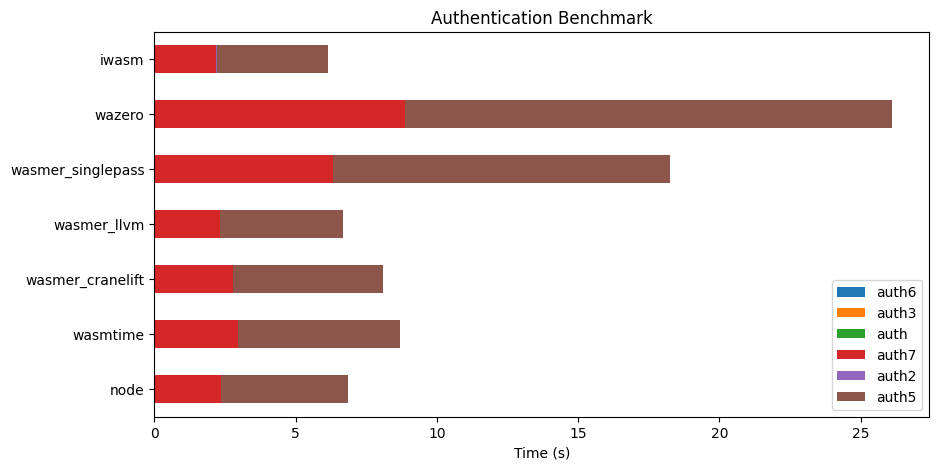

In [17]:
runtimes = ["node", "wasmtime", "wasmer_cranelift", "wasmer_llvm", "wasmer_singlepass", "wazero", "iwasm"]
plot_benchmarks(runtimes, ["auth"], title="Authentication Benchmark", output_file_name="auth_benchmark.pdf")

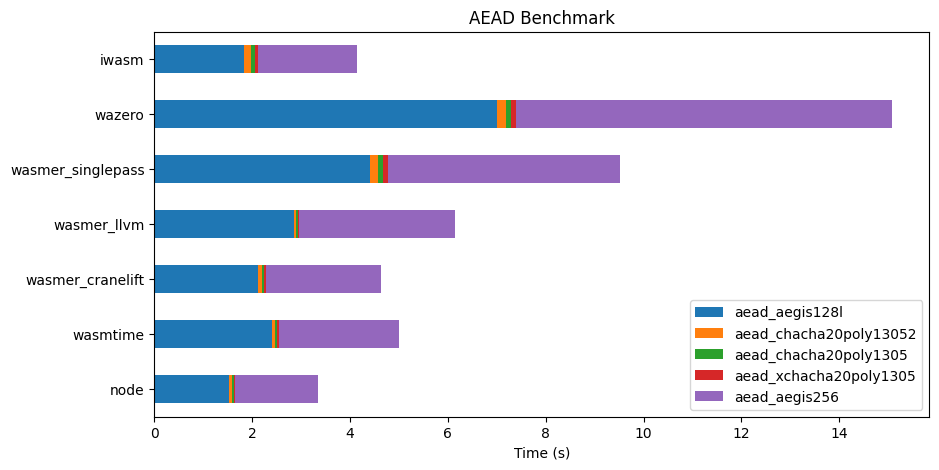

In [18]:
runtimes = ["node", "wasmtime", "wasmer_cranelift", "wasmer_llvm", "wasmer_singlepass", "wazero", "iwasm"]
plot_benchmarks(runtimes, ["aead"], title="AEAD Benchmark", output_file_name="aead_benchmark.pdf")

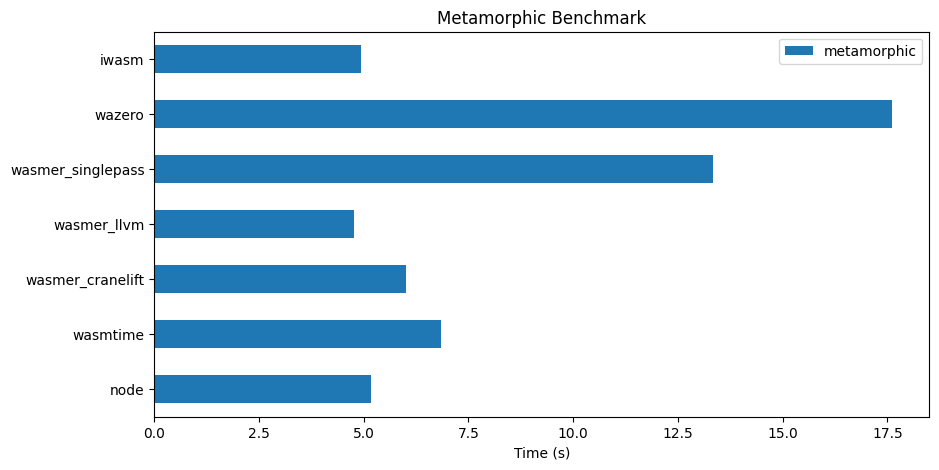

In [19]:
runtimes = ["node", "wasmtime", "wasmer_cranelift", "wasmer_llvm", "wasmer_singlepass", "wazero", "iwasm"]
plot_benchmarks(runtimes, ["metamorphic"], title="Metamorphic Benchmark", output_file_name="metamorphic_benchmark.pdf")

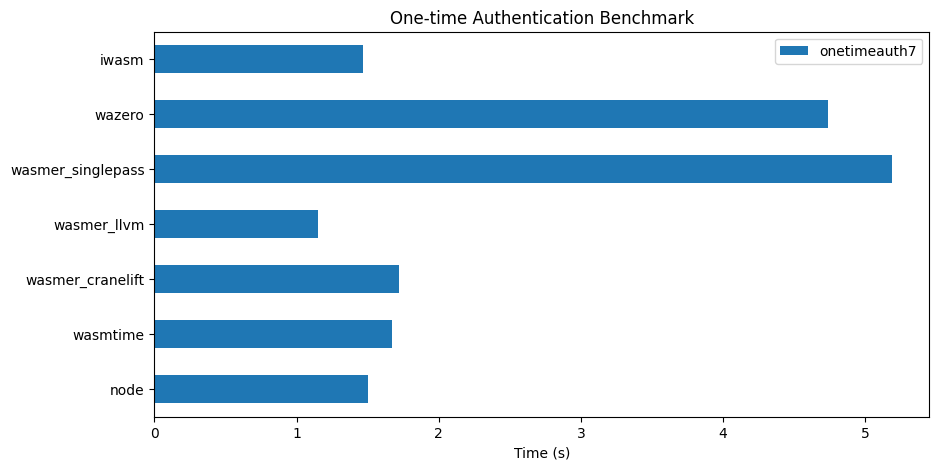

In [20]:
runtimes = ["node", "wasmtime", "wasmer_cranelift", "wasmer_llvm", "wasmer_singlepass", "wazero", "iwasm"]
plot_benchmarks(runtimes, ["onetimeauth"], title="One-time Authentication Benchmark", output_file_name="onetimeauth_benchmark.pdf")

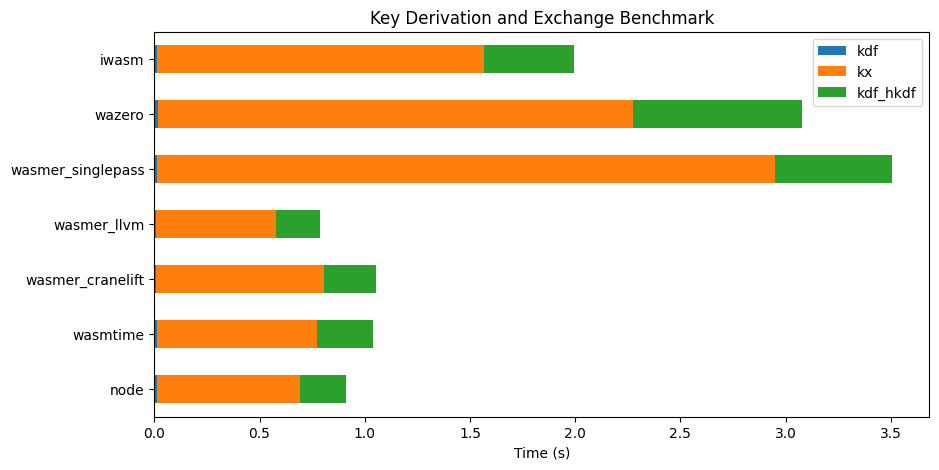

In [21]:
runtimes = ["node", "wasmtime", "wasmer_cranelift", "wasmer_llvm", "wasmer_singlepass", "wazero", "iwasm"]
plot_benchmarks(runtimes, ["kdf1","kdf2"], title="Key Derivation and Exchange Benchmark", output_file_name="kdf_benchmark.pdf")

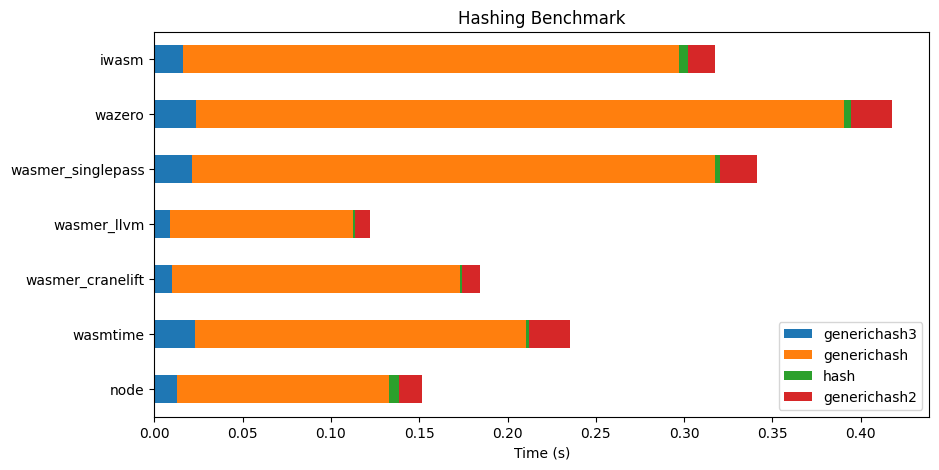

In [22]:
runtimes = ["node", "wasmtime", "wasmer_cranelift", "wasmer_llvm", "wasmer_singlepass", "wazero", "iwasm"]
plot_benchmarks(runtimes, ["hash1","hash2"],title="Hashing Benchmark", output_file_name="hash_benchmark.pdf")

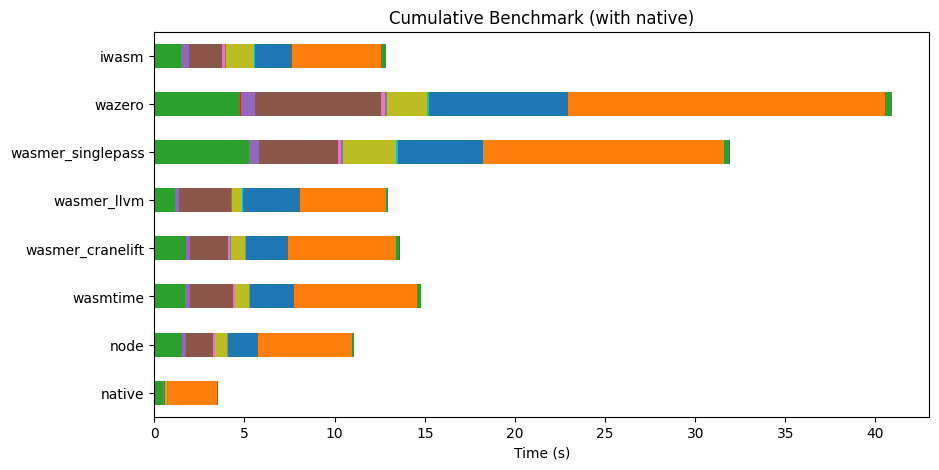

In [52]:
runtimes = ["native","node", "wasmtime", "wasmer_cranelift", "wasmer_llvm", "wasmer_singlepass", "wazero", "iwasm"]
# runtimes = ["native"]
plot_benchmarks(runtimes, ["aead", "hash1", "hash2", "kdf1","kdf2","metamorphic","onetimeauth"], title="Cumulative Benchmark (with native)", output_file_name="auth_benchmark_native.pdf", legend=False)

In [28]:
def plot_best_compared_with_native(runtimes, file_pattern_name_list, title, output_file_name, legend=True):
    files = set()
    data = {}
    tests = {}
    for runtime in runtimes:
        data[runtime] = {}
    for file_pattern_name in file_pattern_name_list:
        tests[file_pattern_name] = set()
        for runtime in runtimes:
            with open(f"output_{runtime}_{file_pattern_name}.txt") as f:
                lines = f.read().splitlines()
                for line in lines:
                    if not line.isnumeric():
                        file = line.split("/")[-1]
                        file = file.split(".")[0]
                        tests[file_pattern_name].add(file)
                        files.add(file)
                        data[runtime][file] = []
                    else:
                        data[runtime][file].append(int(line))
                    line = f.readline()
                    
    # Make a mean of the data
    summed_data = {}
    for runtime in runtimes:
        summed_data[runtime] = {}
        for file in files:
            summed_data[runtime][file] = sum(data[runtime][file]) / len(data[runtime][file])
            
    print(tests)
    tests['hash'] = tests['hash1'].union(tests['hash2'])
    tests['kdf'] = tests['kdf1'].union(tests['kdf2'])
    tests.pop('hash1')
    tests.pop('hash2')
    tests.pop('kdf1')
    tests.pop('kdf2')
    
    new_data = {}
    for test in tests:
        new_data[test] = {}
        for runtime in runtimes:
            new_data[test][runtime] = []
            for file in tests[test]:
                new_data[test][runtime].append(summed_data[runtime][file])
            new_data[test][runtime] = sum(new_data[test][runtime])
    
    # For each test only keep native and the best runtime
    for test in tests:
        new_data[test] = {k: v for k, v in sorted(new_data[test].items(), key=lambda item: item[1])}
        new_data[test] = {k: v for k, v in new_data[test].items() if k == "native" or k == list(new_data[test].keys())[1]}
        
    # Create the dataframe in order to have
    columns = ["test", "Native time", "Best time"]
    df = pd.DataFrame(columns=columns)
    for test in new_data:
        #df = df.append({"test": test, "native_time": new_data[test]["native"], "best_time": new_data[test][list(new_data[test].keys())[0]]}, ignore_index=True)
        # df dont have append
        #df = df.append(pd.Series([test, new_data[test]["native"], new_data[test][list(new_data[test].keys())[0]]], index=df.columns), ignore_index=True)
        df.loc[len(df.index)] = [test, 1, new_data[test][list(new_data[test].keys())[1]] / new_data[test]["native"]]
    
    print(df)
    df.plot.bar(x="test", y=["Native time", "Best time"], rot=0)
    # Make figure bigger
    plt.gcf().set_size_inches(10, 6)
    plt.ylabel('Time / Native time')
    plt.ylim(0, 6)
    plt.title(title)
    plt.savefig(f'./results/{output_file_name}', format="pdf", bbox_inches="tight")

{'auth': {'auth6', 'auth3', 'auth', 'auth7', 'auth2', 'auth5'}, 'aead': {'aead_aegis128l', 'aead_chacha20poly13052', 'aead_chacha20poly1305', 'aead_xchacha20poly1305', 'aead_aegis256'}, 'hash1': {'generichash3', 'generichash', 'generichash2'}, 'hash2': {'hash'}, 'kdf1': {'kx'}, 'kdf2': {'kdf', 'kdf_hkdf'}, 'metamorphic': {'metamorphic'}, 'onetimeauth': {'onetimeauth7'}}
          test  Native time  Best time
0         auth            1   2.044516
1         aead            1  31.392882
2  metamorphic            1   1.763151
3  onetimeauth            1   2.521194
4         hash            1   1.428893
5          kdf            1   3.931751


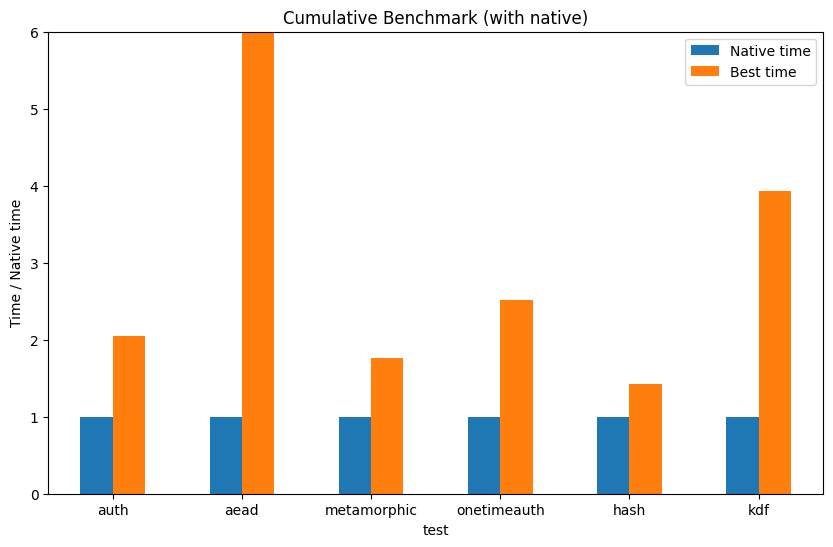

In [29]:
runtimes = ["native","node", "wasmtime", "wasmer_cranelift", "wasmer_llvm", "wasmer_singlepass", "wazero", "iwasm"]
plot_best_compared_with_native(runtimes, ["auth", "aead","hash1", "hash2", "kdf1","kdf2","metamorphic","onetimeauth"], title="Cumulative Benchmark (with native)", output_file_name="best_comparison_native.pdf", legend=False)

In [49]:
import math
def plot_benchmarks2(runtimes, type, title, output_file_name, legend=True):   
    buffer_sizes = set()
    data = {}
    for runtime in runtimes:
        data[runtime] = {}
    
    for runtime in runtimes:
        with open(f"output_{runtime}_{type}.txt") as f:
            lines = f.read().splitlines()
            for line in lines:
                if not '.' in line:
                    size = line.split("/")[-1]
                    buffer_sizes.add(size)
                    data[runtime][size] = []
                else:
                    data[runtime][size].append(float(line))
                line = f.readline()
                    
    print(data)
    
    # Make a mean of the data
    summed_data = {}
    for runtime in runtimes:
        summed_data[runtime] = {}
        for size in buffer_sizes:
            summed_data[runtime][size] = sum(data[runtime][size]) / len(data[runtime][size])
            
    normalized_data = {}
    for runtime in runtimes:
        normalized_data[runtime] = []
        for size in buffer_sizes:
            normalized_data[runtime].append(summed_data[runtime][size])
            
    # Calculate the sum over the rows
    #sums = []
    #for runtime in runtimes:
    #    s = 0
    #    for size in buffer_sizes:
    #        s += summed_data[runtime][size]
    #    sums.append(s)

    # sums_avg = sum(sums) / len(sums)

    # Normalize the new_data dividing by the sum avg
    #for runtime in runtimes:
    #    normalized_data[runtime] = [x / sums_avg for x in normalized_data[runtime]]
        
    for runtime in runtimes:
        x = [math.log2(int(x)) for x in buffer_sizes]
        
        # sort x and normalized data together
        x, normalized_data[runtime] = zip(*sorted(zip(x, normalized_data[runtime])))
        plt.plot(x, normalized_data[runtime], label=runtime)
    
    plt.legend(title='Runtime', bbox_to_anchor=(1.02, 1), loc='upper left')  # Place legend outside the plot
    plt.ylim(0, 2)
    plt.xlabel('Buffer size ($\log_2$)')
    plt.ylabel('Runtime (s)')
    plt.title(title)
    
    # plt.savefig(f'./results/{output_file_name}', format="pdf", bbox_inches="tight")
    if legend:
        plt.savefig(f'./results/{output_file_name}', format="pdf", bbox_inches="tight",  bbox_extra_artists=[plt.legend()])
    else:
        plt.savefig(f'./results/{output_file_name}', format="pdf", bbox_inches="tight")
    
    plt.show()

{'wazero': {'16': [0.873395, 0.890581, 0.881261], '32': [0.437941, 0.442552, 0.440174], '64': [0.233937, 0.228778, 0.230821], '128': [0.128342, 0.12142, 0.116653], '256': [0.061276, 0.058912, 0.060574], '512': [0.032519, 0.033194, 0.035906], '1024': [0.018449, 0.018716, 0.019875], '2048': [0.011843, 0.01218, 0.013077], '4096': [0.007878, 0.007687, 0.009608], '8192': [0.006841, 0.006706, 0.006558], '16384': [0.005138, 0.005517, 0.005856]}, 'iwasm': {'16': [1.570773, 1.48166, 1.467112], '32': [0.746946, 0.755746, 0.756584], '64': [0.394725, 0.388263, 0.398699], '128': [0.208345, 0.213987, 0.204545], '256': [0.1045, 0.104219, 0.108279], '512': [0.057997, 0.053509, 0.059598], '1024': [0.028561, 0.029454, 0.029711], '2048': [0.019037, 0.017394, 0.017419], '4096': [0.011342, 0.011573, 0.010669], '8192': [0.007448, 0.007829, 0.008558], '16384': [0.006858, 0.006488, 0.005785]}, 'node': {'16': [0.878964, 0.9151, 0.907681], '32': [0.442939, 0.438366, 0.470173], '64': [0.228089, 0.221879, 0.22593

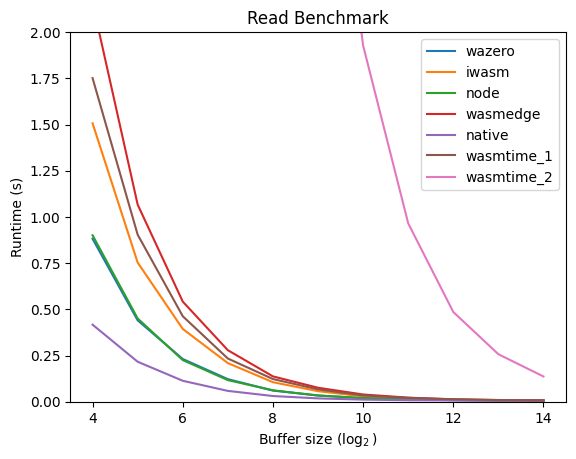

In [50]:
runtimes = ["wazero", "iwasm", "node", "wasmedge", "native", "wasmtime_1", "wasmtime_2"]
plot_benchmarks2(runtimes, 'read', title="Read Benchmark", output_file_name="read_benchmark.pdf")

{'wazero': {'16': [2.337745, 2.317301, 2.336848], '32': [1.167868, 1.177082, 1.160716], '64': [0.600661, 0.612286, 0.589657], '128': [0.318612, 0.313017, 0.313113], '256': [0.168118, 0.167235, 0.167286], '512': [0.089158, 0.08972, 0.09077], '1024': [0.050064, 0.050924, 0.050364], '2048': [0.030001, 0.033622, 0.031963], '4096': [0.020835, 0.023447, 0.021], '8192': [0.018519, 0.017624, 0.01822], '16384': [0.016612, 0.016813, 0.01846]}, 'iwasm': {'16': [3.01508, 2.860378, 2.893114], '32': [1.477023, 1.473117, 1.476222], '64': [0.754048, 0.758438, 0.758545], '128': [0.401283, 0.399692, 0.399409], '256': [0.201474, 0.210138, 0.216902], '512': [0.107355, 0.109013, 0.11506], '1024': [0.057695, 0.060644, 0.060244], '2048': [0.035293, 0.036343, 0.035862], '4096': [0.022061, 0.021761, 0.021707], '8192': [0.018713, 0.019184, 0.018497], '16384': [0.018223, 0.017421, 0.01827]}, 'node': {'16': [2.336813, 2.358034, 2.314514], '32': [1.145934, 1.150429, 1.164972], '64': [0.583348, 0.596345, 0.595479],

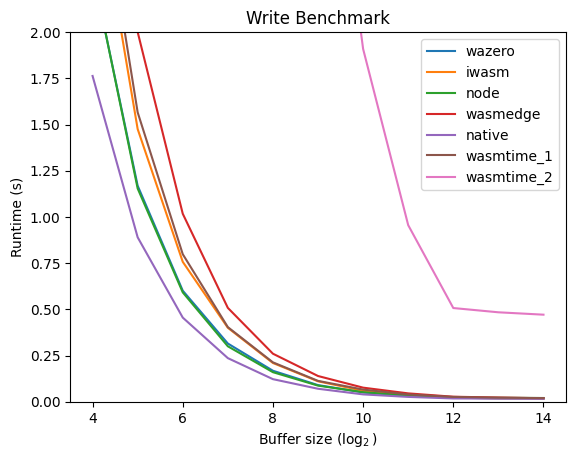

In [51]:
runtimes = ["wazero", "iwasm", "node", "wasmedge", "native", "wasmtime_1", "wasmtime_2"]
plot_benchmarks2(runtimes, 'write', title="Write Benchmark", output_file_name="write_benchmark.pdf")